## Time-Warped ARHMM Example Notebook
### Overview
This notebook illustrates how to use `jax_moseq.models.twarhmm` to fit a time-warped autoregressive hidden Markov model (i.e. TWARHMM) to time series data via Gibbs sampling. We will demonstrate both sampling from a prespecified model and fitting a model to synthetic data.

### Model
#### Intuition
Our model seeks to enhance the traditional ARHMM model by adding a "time constant" state $\tau$. To build intuition, note that we can think of running an ARHMM forward as adding an update to our current observation at each time point, which relies on our prior observation and current state:

$x_{t+1} = x_t + A_{z_t}x_t + b_{z_t}$

In the time-warped ARHMM, we add a scalar multiplier to this update:

$x_{t+1} = x_t + \frac{1}{\tau_t}(A_{z_t}x_t + b_{z_t})$

$\tau_t$ effectively controls the rate or speed at which the update is applied, while $z_t$ specifies the current discrete syllable that defines the update. As a concrete example, in the MoSeq case we can think of $z_t$ as our current syllable and $\tau_t$ as the relative "vigor" at which it's executed. In this way, the time-warped ARHMM is able to group together movements with similar kinematics occurring at different speeds.

#### Formalism
The TWARHMM has the following learnable states and parameters.
- the discrete latent state sequence: $Z = \{ z_t \in \{ 1, ..., N \} \}_{t=1}^{T}$
- the 'continuous' latent state sequence: $\Tau = \{ \tau_t \in \{ 1, ..., M \} \}_{t=1}^{T}$
- the continuous observations: $X = \{ x_t \in \mathbb{R}^{d} \}_{t=1}^{T}$
- the Markov discrete state transition matrix: $\pi_z \in \mathbb{R}^{N \times N}$
- The autoregressive parameters: $\Theta = \{ A^{(i)} \in \mathbb{R}^{d \times \ell d},
                                              b^{(i)} \in \mathbb{R}^{d},
                                              Q^{(i)} \in \mathbb{R}^{d \times d}\}_{i=1}^{N}$.

Above $d$ denotes the dimensionality of our observations, $N$ denotes the number of discrete states in our model, and $M$ denotes the number of possible $\tau$ values.

Then the parameters of the model are related as follows:
- $\pi_z \sim \text{Dir}(\alpha \beta_1 + \kappa \delta_{i1}, \dots, \alpha \beta_N + \kappa \delta_{iN})$
- $(A^{(i)},b^{(i)}), Q^{(i)} \sim \text{MNIW}(\nu_0, S_0, M_0, K_0)$
- $z_t \sim \text{Categorical}(\pi_{z_{t-1}})$
- $\tau_t \sim \text{Categorical}(\pi_{\tau_{t-1}})$ 
    - This transition matrix is pre-specified using the hyperparameter `t_stick` described below. It is structured to constrain $\tau_t$ to transition only between consecutive values, mimicking continuous changes. 
- $x_t \sim \mathcal{N}(x_{t-1} + \frac{1}{\tau_{t}}A^{(z_t)} x_{t-1} + b^{(z_t)}, \frac{1}{\tau_{t^2}}Q^{(z_t)})$

The hyperparameters are defined as follows:

- The bias towards self transitions: $\kappa \geq 0$
- The pseudo-counts for each transition in the transition matrix: $\beta \geq 0$
- The inverse-Wishart degrees of freedom for the AR noise covariances: $n_0 
\in \mathbb{N}_{\geq d}$
- The inverse-Wishart scale for the AR noise covariances: $S_0 \in \mathbb{R}^{d \times d}$
- The matrix normal expectation for the AR transforms: $M_0 \in \mathbb{R}^{d \times \ell d + 1}$
- The matrix normal column scale for the AR transforms: $K_0 \in \mathbb{R}^{\ell d + 1 \times \ell d + 1}$
- The "stickiness" parameter for $\tau$ transitions: `t_stick` $\in [0,1]$

#### Fitting
We fit the model using Gibbs Sampling. As a reminder, Gibbs sampling is a Markov chain Monte Carlo (MCMC) algorithm that's useful for sampling from the posterior distribution of a probabilistic graphical model. More plainly, we have some observations ($X$) and we'd like to learn a set of latent states ($Z, \Tau$) and parameters ($\pi, \beta, \Theta$) that are compatible those observations, subject to certain priors on the model (specified by the hyperparameters). To do so, after randomly initializing the model, we cycle through its parameters and latents, resampling each variable given the current states of each of the other variables (`jax_moseq.models.twarhmm.gibbs` for the implementation). After enough iterations of this process we should learn a reasonable set of latent states and parameters.

Note: since our latent state trajectories $Z$ and $\Tau$ have independent transition matrices, we are able to save some computational cost when resampling the discrete state sequences (compared to expanding out the transition matrix for the pair of latents $(z, \tau)$). As such, there's a custom implementation of `sample_hmm_stateseq` in `jax_moseq.models.twarhmm.gibbs`.

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr

from jax_moseq.utils.autoregression import random_rotation

from jax_moseq.models import twarhmm

from tqdm.auto import trange
import matplotlib.pyplot as plt

import seaborn as sns
from dynamax.utils.plotting import gradient_cmap

sns.set_style("white")
sns.set_context("talk")


color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink",
    "greyish",
    "mint",
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)


/Users/costacurta/jax-moseq/.conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# helper functions

def print_dict(d, depth=0, ind='  '):
    if type(d) != dict:
        try:
            item = d.shape
        except AttributeError:
            item = d
        print(f'{ind * depth}{item}')
        return
    
    for k, v in d.items():
        print(f'{ind * depth}{k}')
        print_dict(v, depth + 1, ind)

def plot_ll(key, ll_history):
    plt.title(f'Log Likelihood of {key}')
    plt.xlabel('Iteration')
    plt.ylabel('Log Likelihood')
    plt.plot(ll_history)
    plt.show()

## Data Generation

Here, we demonstrate the ability to generate data from a TWARHMM model using `twarhmm.generate`.

In [3]:
# first, define model parameters
true_num_states = 5
num_sessions = 1
num_timesteps = 20000
emission_dim = 2
seed = jr.PRNGKey(23)
tau_values = jnp.array([0.75, 1, 1.33])

# weights + biases for "starfish" example
keys = jr.split(jr.PRNGKey(0), true_num_states)
angles = jnp.linspace(0, 2 * jnp.pi, true_num_states, endpoint=False)
theta = jnp.pi / 25 # rotational frequency
weights = jnp.array([0.8 * random_rotation(key, emission_dim, theta=theta) for key in keys])
biases = jnp.column_stack([jnp.cos(angles), jnp.sin(angles), jnp.zeros((true_num_states, emission_dim - 2))])
covariances = jnp.tile(0.001 * jnp.eye(emission_dim), (true_num_states, 1, 1))

true_Ab = jnp.concatenate((weights - jnp.eye(2), biases[:,:,None]), axis=-1)
true_Q = covariances

# transition matrices for z and tau
transition_probs = 0.1 ** jnp.arange(true_num_states)
transition_probs /= transition_probs.sum()
transition_matrix = jax.vmap(lambda k: jnp.roll(transition_probs, k))(jnp.arange(true_num_states))

true_pi_z = transition_matrix
true_pi_t = jnp.array([[0.90, 0.10, 0.00], 
                  [0.05, 0.90, 0.05],
                  [0.00, 0.10, 0.90]])


In [4]:
# generate data
true_zs, true_ts, xs = jax.vmap(
    lambda seed: twarhmm.generate.generate_states(seed, true_pi_z, true_pi_t, true_Ab, true_Q, tau_values, num_timesteps)
    )(jr.split(seed, num_sessions))

data = {'x': jax.device_put(xs),
        'mask': jax.device_put(jnp.ones_like(true_zs))} #TODO: get rid of masks

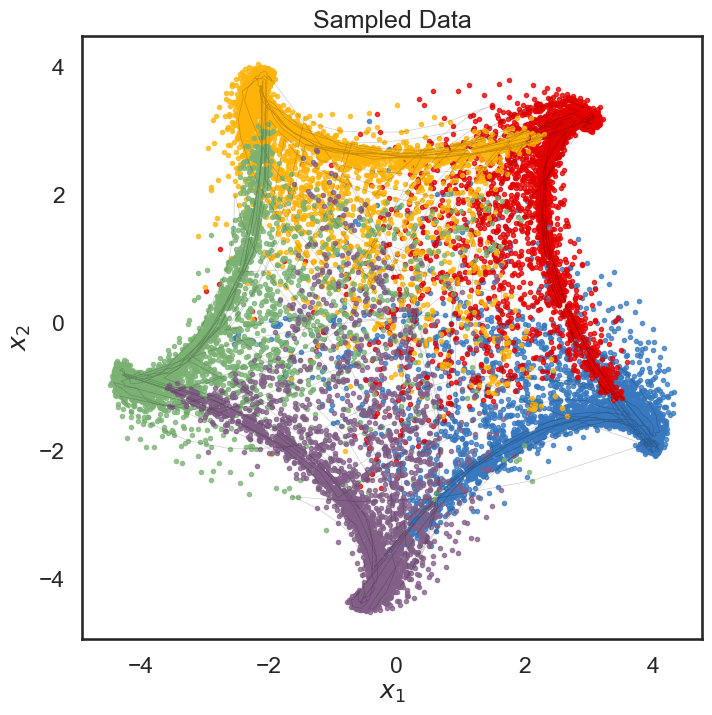

In [5]:
# Plot the sampled data
fig = plt.figure(figsize=(8, 8))
for k in range(true_num_states):
    plt.plot(*xs[0][true_zs[0]==k].T, 'o', color=colors[k],
         alpha=0.75, markersize=3)

plt.plot(*xs[0,:1000].T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Sampled Data")
plt.gca().set_aspect(1.0)

## Model Fitting

Now, we'll fit a randomly initialized TWARHMM to this data using Gibbs sampling.

In [ ]:
latent_dim = obs_dim = data['x'].shape[-1] # dimensionality of data
num_states = 10   # number of discrete states in model
tau_values = jnp.array([0.5, 1, 2]) # potential tau values

# define hyperparameters
trans_hypparams = {
    'beta': 100.0,
    'kappa': 100.0,
    'num_states':num_states,
    't_stick': 0.8
}

ar_hypparams = {
    'S_0_scale': .01,
    'K_0_scale': 10,
    'num_states':num_states,
    'latent_dim': latent_dim,
    'tau_values': tau_values
}

In [15]:
# randomly initialize model
init_seed = jr.PRNGKey(13)
model = twarhmm.init_model(data,
                           seed=seed,
                           ar_hypparams=ar_hypparams,
                           trans_hypparams=trans_hypparams,
                           verbose=True)

print_dict(model)

TWARHMM: Initializing hyperparameters
TWARHMM: Initializing parameters
TWARHMM: Initializing states
seed
  (2,)
hypparams
  trans_hypparams
    beta
      100.0
    kappa
      100.0
    num_states
      10
    t_stick
      0.95
  ar_hypparams
    S_0_scale
      0.01
    K_0_scale
      10
    num_states
      10
    latent_dim
      2
    S_0
      (2, 2)
    K_0
      (3, 3)
    M_0
      (2, 3)
    nu_0
      4
params
  pi_z
    (10, 10)
  tau_values
    (3,)
  pi_t
    (3, 3)
  Ab
    (10, 2, 3)
  Q
    (10, 2, 2)
states
  z
    (1, 19999)
  t
    (1, 19999)


In [16]:
num_iters = 100    # number of training iterations

ll_keys = ['z', 'x', 't']
ll_history = {key: [] for key in ll_keys}

for i in trange(num_iters):
    # Perform Gibbs resampling
    ll = twarhmm.model_likelihood(data, **model)
    model = twarhmm.resample_model(data, **model, states_only=False)
    
    # Compute the likelihood of the data and
    # resampled states given the resampled params
    for key in ll_keys:
        ll_history[key].append(ll[key].item())

100%|██████████| 100/100 [00:06<00:00, 15.07it/s]


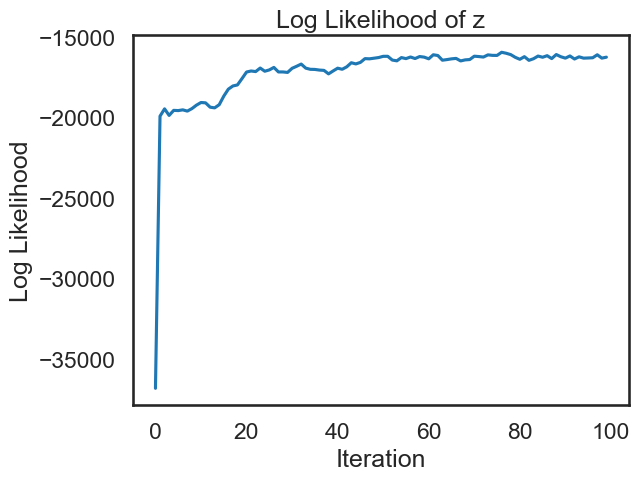

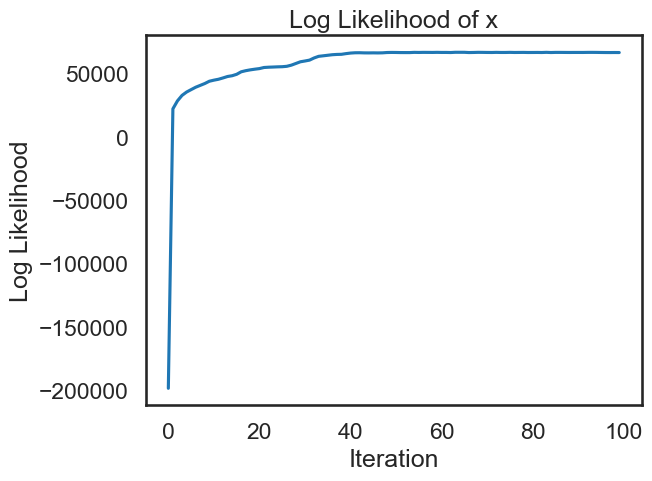

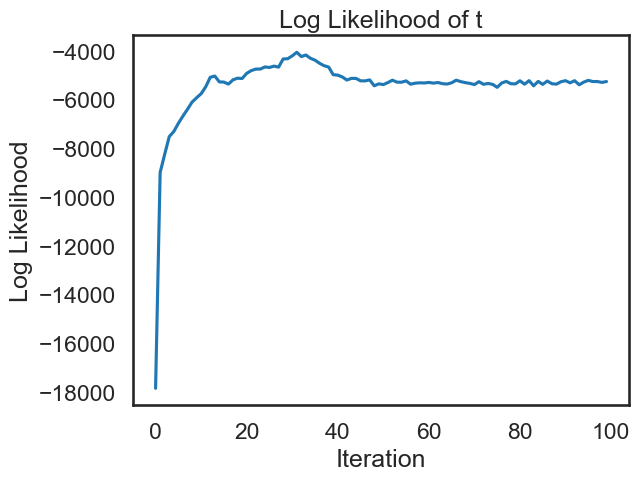

In [17]:
# plot likelihoods of latents and data
for k, v in ll_history.items():
    plot_ll(k, v)

Text(0, 0.5, '$x_2$')

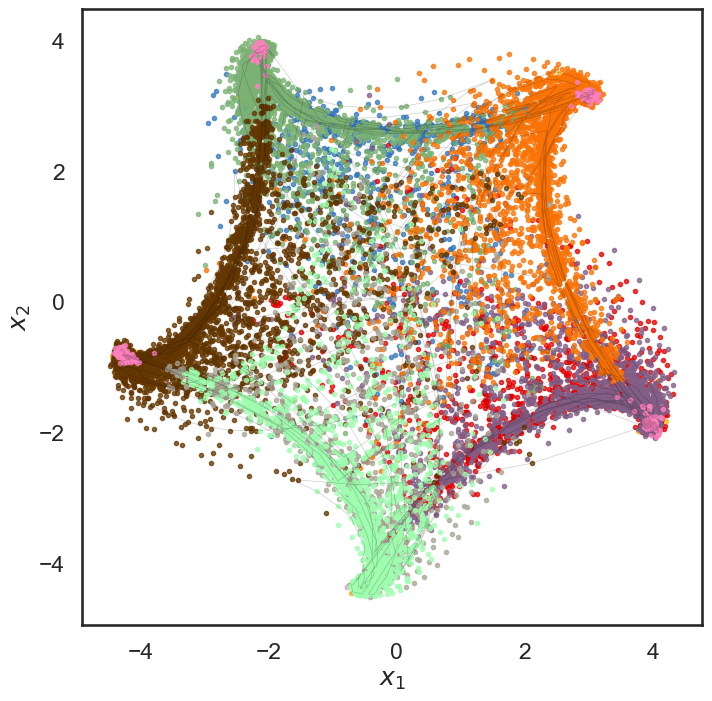

In [18]:
# Plot the data with the inferred states
fig = plt.figure(figsize=(8, 8))
for k in range(num_states):
    plt.plot(*xs[0,1:][model['states']['z'][0]==k].T, 'o',
         color=colors[k], alpha=0.75, markersize=3)

plt.plot(*xs[0,:1000].T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

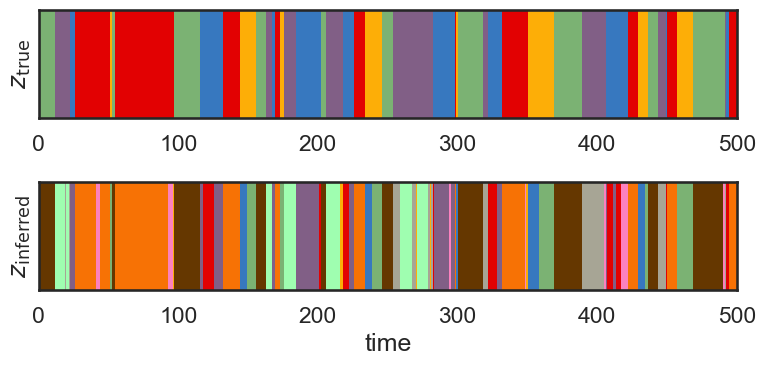

In [19]:
# another plot comparing true and inferred states

plot_slice = (0, 500)
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(true_zs[None, 0, 1:], aspect="auto", interpolation="none", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
plt.imshow(model['states']['z'][None,0,:], aspect="auto", interpolation="none", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

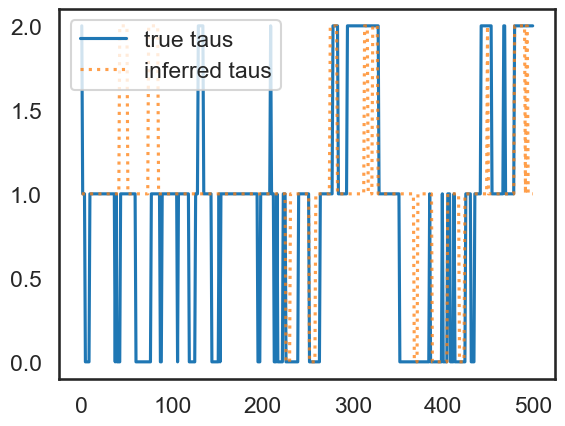

In [20]:
# true and inferred taus

plt.plot(true_ts[0,:500], label='true taus')
plt.plot(model['states']['t'][0,:500], ':', alpha=0.75, markersize=3, label='inferred taus')
plt.legend()

## Compute the overlap between true and inferred states

Here, we generate some plots to see if we've correctly identified the underlying latents, up to permutation. If our model has captured the underlying data, we should see heavy overlap between 5 of the model-inferred states and our 5 true states. We should also see heavy overlap between true and inferred taus.

Text(0, 0.5, 'true state')

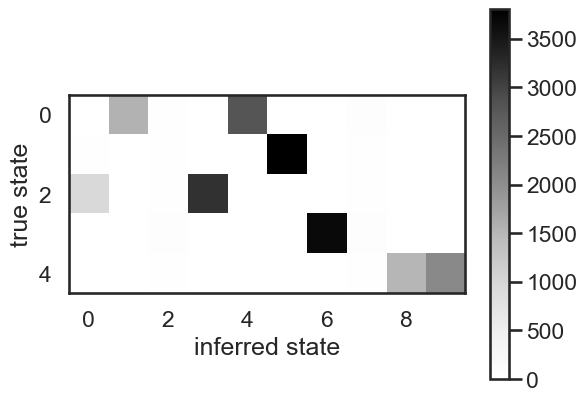

In [21]:
z_overlap = jnp.zeros((true_num_states, num_states))
# Loop over sessions and pairs of states
for z, true_z in zip(model["states"]["z"], true_zs):
    for i in range(true_num_states):
        for j in range(num_states):
            z_overlap = z_overlap.at[i, j].add(jnp.sum((true_z[1:] == i) & (z == j)))

plt.imshow(z_overlap, cmap="Greys", interpolation="nearest", aspect="1")
plt.colorbar()
plt.xlabel("inferred state")
plt.ylabel("true state")

Text(0, 0.5, 'true tau')

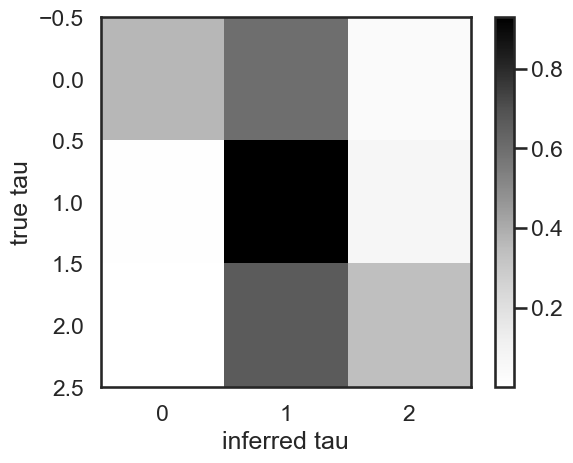

In [22]:
true_num_taus = num_taus = 3
t_overlap = jnp.zeros((true_num_taus, num_taus))
# Loop over sessions and pairs of taus
for t, true_t in zip(model["states"]["t"], true_ts):
    for i in range(true_num_taus):
        for j in range(num_taus):
            t_overlap = t_overlap.at[i, j].add(jnp.sum((true_t[1:] == i) & (t == j)))

plt.imshow(t_overlap / t_overlap.sum(axis=1, keepdims=True), 
           cmap="Greys", interpolation="nearest", aspect="1")
plt.colorbar()
plt.xlabel("inferred tau")
plt.ylabel("true tau")